# **Speech Recognition with Neural Networks**

### **Project Overview:**

The primary objective of this project is to investigate and compare diverse speech signal representations in the context of a classification task. The specific focus is on efficiently classifying English numbers within audio recordings using a Multilayer Perceptron (MLP) model.

### **Project Structure:**

**1. Environment Setup:**  
> Import the necessary packages.

**2. Data Preparation:**  
>  Retrieve required data from the dataset.

**3. Data Preprocessing:**  
> Gain a deeper understanding of speech signals through an examination of dataset distribution plots. Implement essential preprocessing steps, such as removing silence periods, applying zero-padding, and normalization, to optimize their suitability for subsequent classification tasks.

**4. Building Model:**  
> Develop and train a Multilayer Perceptron (MLP) model, emphasizing three distinct speech signal representations:
   
        4.1. Time-domain Signal
        4.2. Short-Time Fourier Transform (STFT)
        4.3. Mel Frequency Cepstral Coefficients (MFCC)
        
**5. Conclusion:**  
> Summarize findings and insights gained from the comparison.

## 1. Environment Setup

In [1]:
import time
import hub
import numpy as np
import pandas as pd
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline

In [2]:
# # Ignore warnings
# import warnings 
# warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()
FIG_SIZE = (12, 4)
FONT_SIZE = 16

In [4]:
RANDOM_STATE = 99

## 2. Data Preparation

### 2.1. Data Loading

In [5]:
ds = hub.load("hub://activeloop/spoken_mnist")

|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



/

hub://activeloop/spoken_mnist loaded successfully.



In [6]:
print(ds)

Dataset(path='hub://activeloop/spoken_mnist', read_only=True, tensors=['spectrograms', 'labels', 'audio', 'speakers'])


In [7]:
# ds.visualize()

In [8]:
ds.summary()

Dataset(path='hub://activeloop/spoken_mnist', read_only=True, tensors=['spectrograms', 'labels', 'audio', 'speakers'])

    tensor        htype             shape           dtype  compression
   -------       -------           -------         -------  ------- 
 spectrograms     image       (3000, 64, 64, 4)     uint8    None   
    labels     class_label        (3000, 1)        uint32    None   
    audio         audio     (3000, 1148:18262, 1)   None      wav   
   speakers       text            (3000, 1)          str     None   


Text(0.5, 1.0, "{'value': 'george'} spoke [0]")

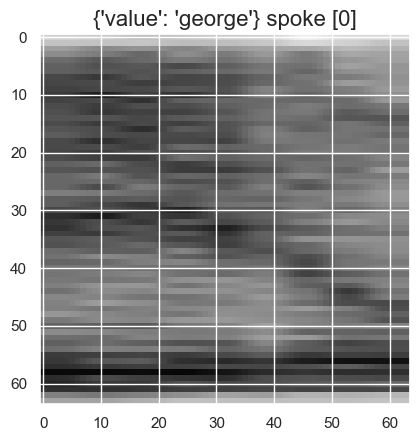

In [9]:
plt.imshow(ds.spectrograms[0].numpy())
plt.title(f"{ds.speakers[0].data()} spoke {ds.labels[0].numpy()}", fontsize=FONT_SIZE)

### 2.2. Audio Data Loading


In this scenario, vocal signals are extracted from the "free-spoken-digit-dataset," available at https://github.com/Jakobovski/free-spoken-digit-dataset. The dataset comprises spoken digit utterances produced by six speakers at a sampling frequency of $8 kHz$.

In [10]:
SAMPLING_RATE = 8000

In [11]:
audio_list = ds.audio.numpy(aslist=True)

In [12]:
audio_list[0][:,0].shape

(2384,)

In [13]:
labels_list = ds.labels.numpy(aslist=True)

In [14]:
labels_list[0][0]

0

In [15]:
X_raw = []
y_raw = []

# Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
for i, audio_i in enumerate(audio_list):
  X_raw.append(audio_list[i][:,0])
  y_raw.append(labels_list[i][0])

In [16]:
len(X_raw), len(y_raw)

(3000, 3000)

In [17]:
y = np.array(y_raw)
np.unique(y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint32),
 array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300], dtype=int64))

### 2.3. Example Presentation: Temporal Signal

In [18]:
index = 4
x = X_raw[index]
print('The pronounced digit is :', y[index])

The pronounced digit is : 0


In [19]:
ipd.Audio(x, rate=SAMPLING_RATE)

In [20]:
def plot_waveform(x):
  """
  Plot the temporal waveform of the input signal x.
  """
  plt.figure(figsize=FIG_SIZE)
  librosa.display.waveshow(y=x, sr=SAMPLING_RATE)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("Time-domain Speech Signal", fontsize=FONT_SIZE)

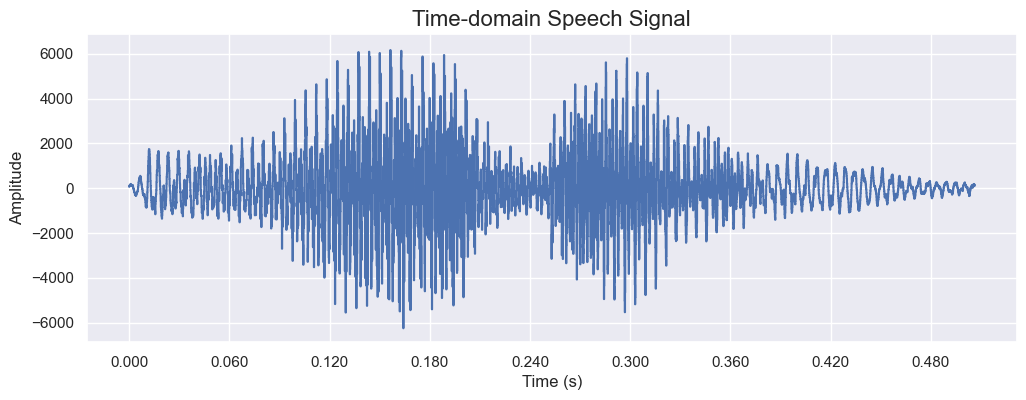

In [21]:
plot_waveform(x)

## 3. Data Preprocessing

### 3.1. Dataset Distribution

In [22]:
def hist_dist_duration(X):
  """
  Plot the distribution of the dataset in terms of duration.
  """
  sample_duration = [len(x)/SAMPLING_RATE for x in X]
  
  plt.figure(figsize=FIG_SIZE)
  sns.histplot(x=sample_duration, bins='fd', kde=True)
  plt.xlabel("Time (s)")
  plt.ylabel("Number of Samples")
  plt.title("Dataset Duration Distribution", fontsize=FONT_SIZE)

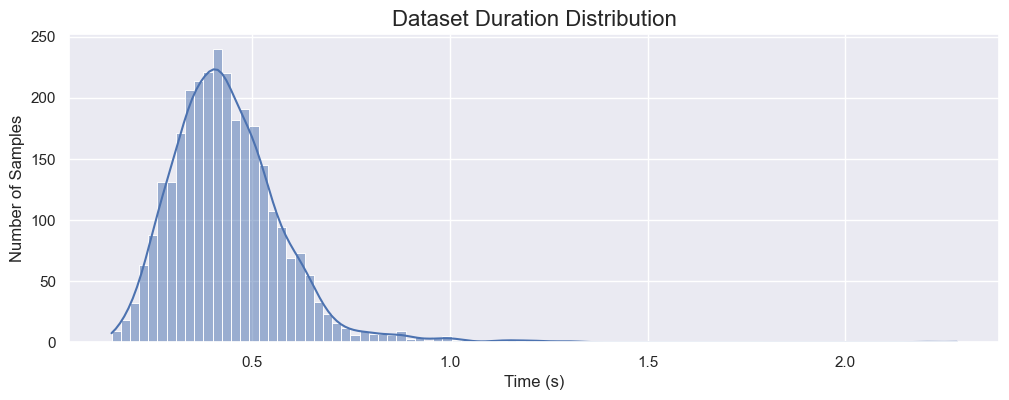

In [23]:
hist_dist_duration(X_raw)

In [24]:
def hist_dist_amplitude(X):
    """
    Plot the distribution of the dataset in terms of MaxAbs amplitude.
    """
    # sample_amplitude = np.concatenate([x for x in X])
    sample_amplitude = [np.max(np.abs(x)) for x in X]
    
    plt.figure(figsize=FIG_SIZE)
    sns.histplot(x=sample_amplitude, bins='fd', kde=True)
    plt.xlabel("Amplitude")
    plt.ylabel("Number of Samples")
    plt.title("Dataset MaxAbs Amplitude Distribution", fontsize=FONT_SIZE)

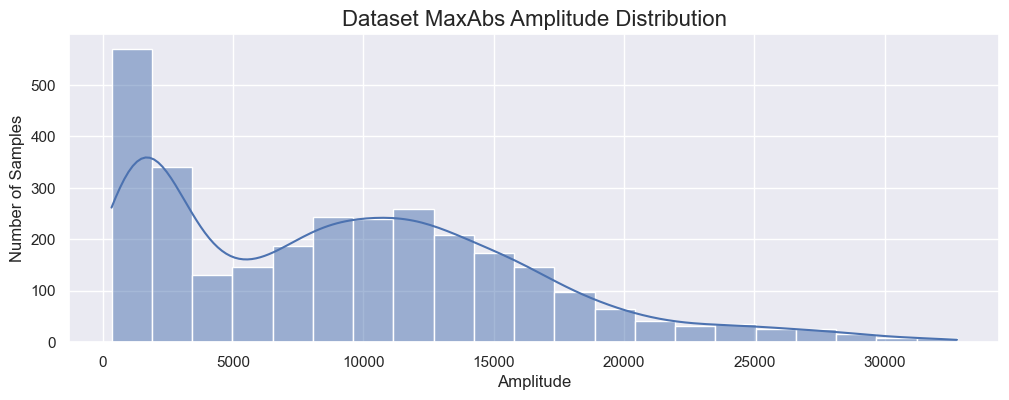

In [25]:
hist_dist_amplitude(X_raw)

In [26]:
def hist_dist_silence(X, top_db = 10, remove_non_silent=True):
    """
    Plot the distribution of the dataset in terms of silence periods.
    """
    sample_silence_len = []
    for x in X:
        x_trimmed, _ = librosa.effects.trim(np.array(x), top_db=top_db)
        sample_silence_len_x = len(x)-len(x_trimmed)
        sample_silence_len.append(sample_silence_len_x/SAMPLING_RATE)

    sample_silence_len_wo_ns = [i for i in sample_silence_len if i != 0]
    percentage_with_silence = 100 * len(sample_silence_len_wo_ns)/len(X)
    print(f"- {round(percentage_with_silence, 2)}% data samples have silence periods")
    
    if remove_non_silent:
        sample_silence_len = sample_silence_len_wo_ns
    
    plt.figure(figsize=FIG_SIZE)
    sns.histplot(x=sample_silence_len, bins='fd', kde=True)
    plt.xlabel("Silence Duration (s)")
    plt.ylabel("Number of Samples")
    plt.title("Dataset Silence Duration Distribution", fontsize=FONT_SIZE)

- 69.23% data samples have silence periods


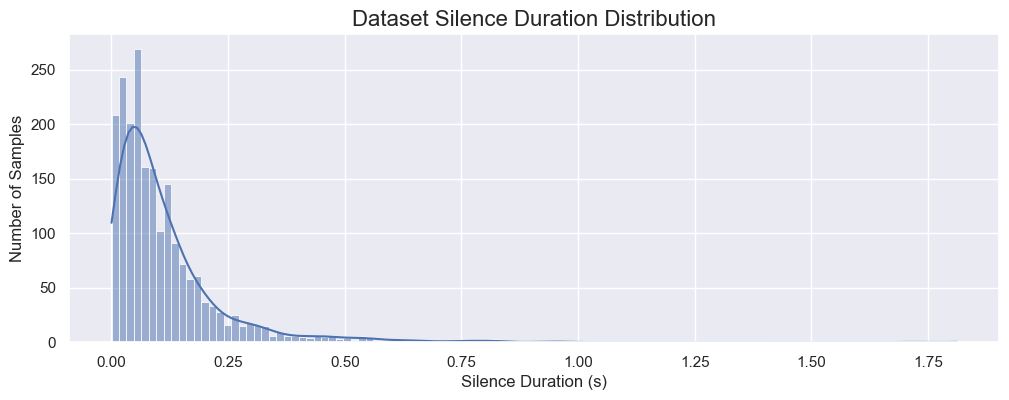

In [27]:
hist_dist_silence(X_raw)

### 3.2. Silence Removal

In [28]:
def remove_silence(x, sr=SAMPLING_RATE, top_db = 10):
    """
    Remove silence periods at the beginning and end of audio signals.
    """
    x_trimmed, _ = librosa.effects.trim(np.array(x), top_db=top_db)
    return x_trimmed

#### Example

The code below presents an example of a signal before and after removing silence periods.

In [29]:
# for i in range(len(X_raw)):
#     signal = X_raw[i]
#     len_1 = len(signal)/SAMPLING_RATE
#     signal_rs = remove_silence(signal)
#     len_2 = len(signal_rs)/SAMPLING_RATE
#     if len_1 - len_2 > 1:
#         print(f'- i = {i}: {len_1} - {len_2}')

In [30]:
n = 2908
signal = X_raw[n]

In [31]:
ipd.Audio(signal, rate=SAMPLING_RATE)

In [32]:
print('The length of the speech signal before silence removal is:', len(signal)/SAMPLING_RATE, 's')

The length of the speech signal before silence removal is: 2.28275 s


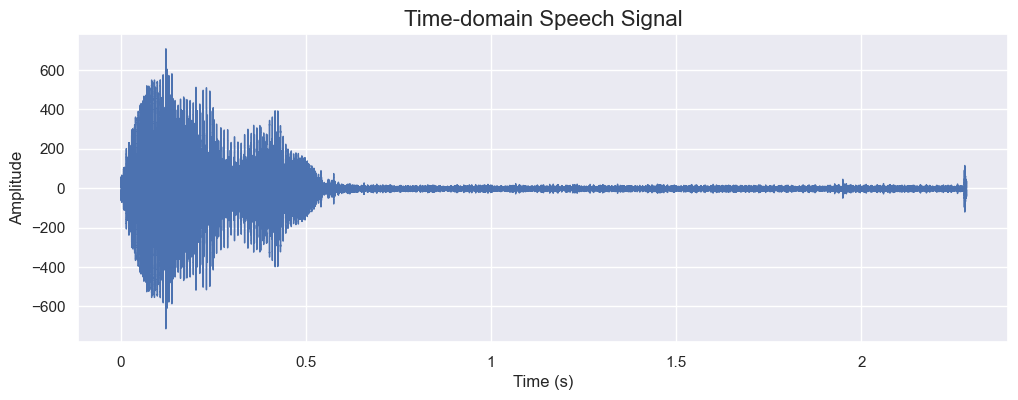

In [33]:
plot_waveform(signal)

The code below presents the signal after removing silence periods.

In [34]:
signal_rs = remove_silence(signal)

In [35]:
ipd.Audio(signal_rs, rate=SAMPLING_RATE)

In [36]:
print('The length of the speech signal after silence removal is:', len(signal_rs)/SAMPLING_RATE, 's')

The length of the speech signal after silence removal is: 0.576 s


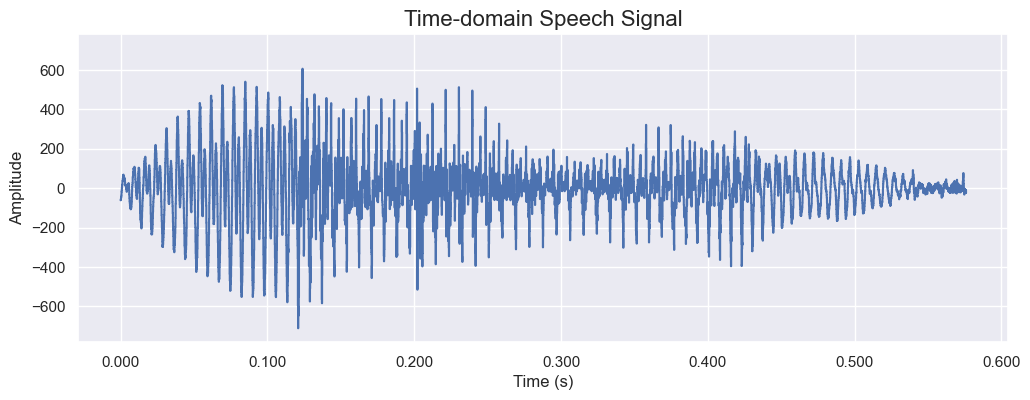

In [37]:
plot_waveform(signal_rs)

#### Silence Removal: database¶

In [38]:
X_rs = [remove_silence(x) for x in X_raw]

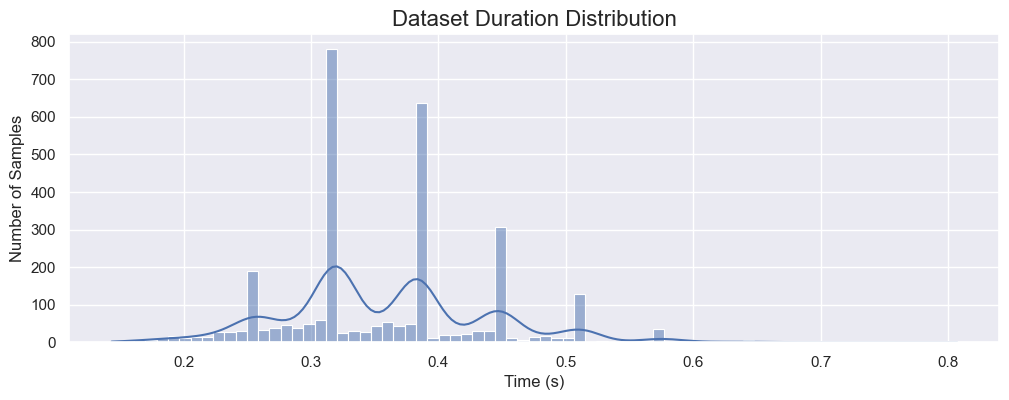

In [39]:
hist_dist_duration(X_rs)

### 3.3. Zero padding

In [40]:
audio_len_list = [len(x) for x in X_rs]

In [41]:
audio_len = int(np.max(audio_len_list))
# audio_len = int(np.quantile(audio_len_list, 0.99))
# audio_len = int(0.7*SAMPLING_RATE)

In [42]:
print(f"audio_len : {audio_len / SAMPLING_RATE} s")

audio_len : 0.807125 s


In [43]:
def zero_padding(x, max_len):
    """
    Align audio signals by padding shorter signals with zeros to match the length of the longest signal.
    """ 
    if len(x) < max_len:
        return np.pad(x, (0, max_len - len(x)), constant_values = (0, 0))
    else:
        return x[:max_len]

#### Zero padding: database

In [44]:
X_pad = [zero_padding(x, audio_len) for x in X_rs]

### 3.4. Normalization

In [45]:
def normalize(x):
    """
    Normalize audio signals.
    """
    # x_norm = librosa.util.normalize(x)
    max_abs_value = max(np.abs(np.max(x)), np.abs(np.min(x)))
    x_norm = x / max_abs_value
    return x_norm

#### Example

The code below presents an example of a signal before and after normalization.

In [46]:
signal = X_pad[9]

In [47]:
ipd.Audio(signal, rate=SAMPLING_RATE)

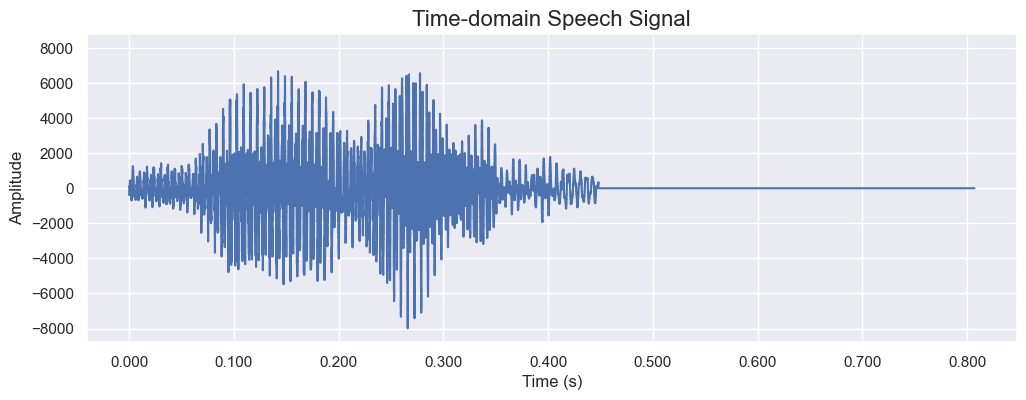

In [48]:
plot_waveform(signal)

In [49]:
signal_norm = normalize(signal)

In [50]:
ipd.Audio(signal_norm, rate=SAMPLING_RATE)

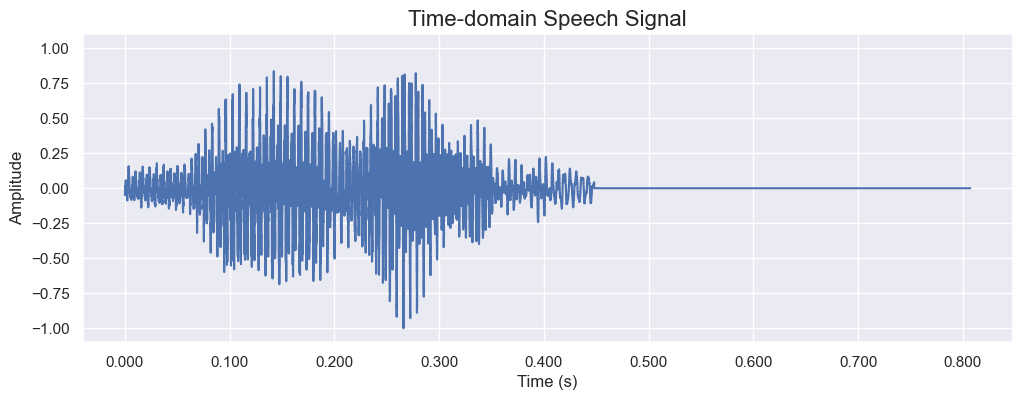

In [51]:
plot_waveform(signal_norm)

#### Normalization: database

In [52]:
X_norm = [normalize(x) for x in X_pad]

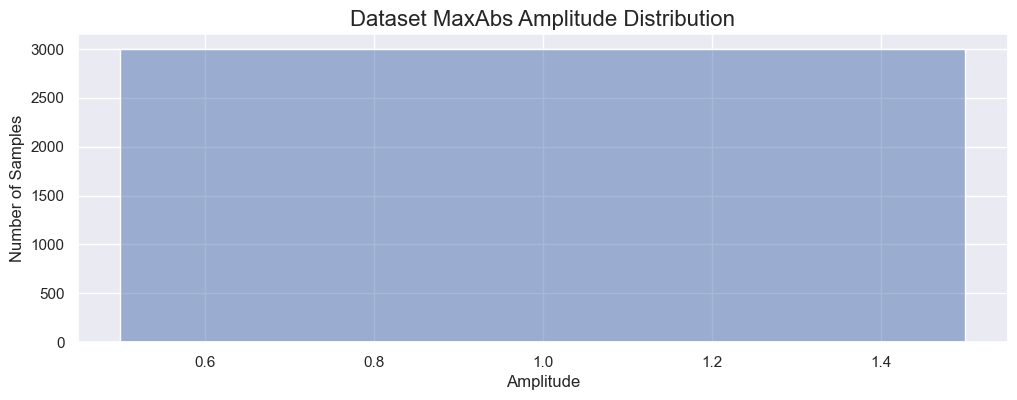

In [53]:
hist_dist_amplitude(X_norm)

#### List to Array: database

In [54]:
X = np.array(X_norm)

In [55]:
X.shape

(3000, 6457)

## 4. Building Model

### 4.1. Input Type: Temporal Signal

#### 4.1.1 Visualization of an example

In [56]:
signal_t = X[11]

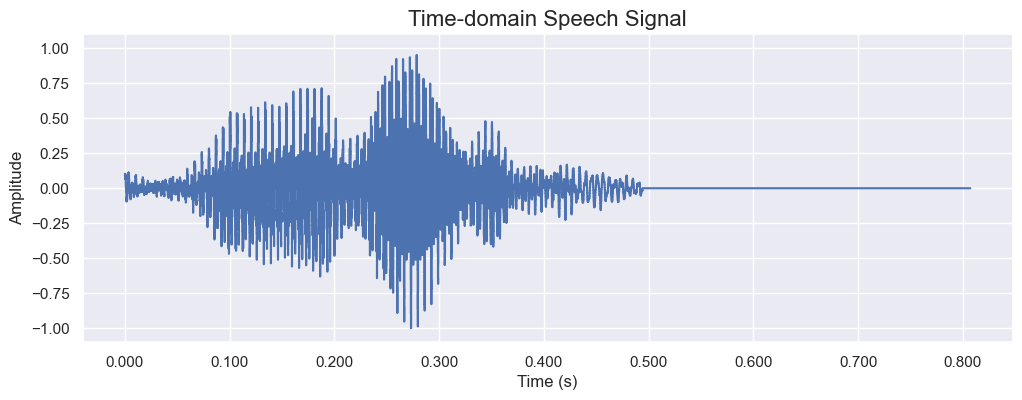

In [57]:
plot_waveform(signal_t)

#### 4.1.2 Create a custom transformer

In [58]:
# scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = MaxAbsScaler()

**Transforming the audio signal into $n$ bins**

The function below creates bins of equal width, calculates the mean and standard deviation within these bins to form the input data for the neural network.

In [59]:
def into_bins_transform(X, nb_bins, nb_digits=4):
    """
    Calculate mean and standard deviation statistics within fixed number of bins for each data sample.
    """
    X_mean_sd = []
    for x in X:
        x_mean_sd = []
        x_array = np.array_split(np.array(x), nb_bins)
        
        for bin in x_array:
            bin_mean = np.round(bin.mean(), nb_digits)
            bin_sd = np.round(bin.std(), nb_digits)
            x_mean_sd.extend([bin_mean, bin_sd])

        X_mean_sd.append(x_mean_sd)
    return np.array(X_mean_sd)

In [60]:
bin_stats_transformer = FunctionTransformer(func=into_bins_transform)

#### 4.1.3. Split the data into training and testing sets

In [61]:
print(f"- X.shape = {X.shape} \t- y.shape = {y.shape}")

- X.shape = (3000, 6457) 	- y.shape = (3000,)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

In [63]:
print(f"""
- X_train.shape = {X_train.shape} \t- y_train.shape = {y_train.shape}
- X_test.shape \t= {X_test.shape} \t- y_test.shape \t= {y_test.shape}
""")


- X_train.shape = (2400, 6457) 	- y_train.shape = (2400,)
- X_test.shape 	= (600, 6457) 	- y_test.shape 	= (600,)



#### 4.1.4. Define pipeline

In [64]:
pipeline = Pipeline([
    ('binning', bin_stats_transformer),
    ('classifier', MLPClassifier())
])

#### 4.1.5. Hyperparameters tuning

In [65]:
param_grid = [{"binning__kw_args": [{'nb_bins': 20}, {'nb_bins': 40}, {'nb_bins': 60}],
               "classifier__activation" : ['tanh','relu', 'logistic'],
               "classifier__alpha": [1e-4, 1e-3, 1e-2],
               "classifier__solver" : ['sgd', 'adam'],
               # "classifier__hidden_layer_sizes": [(10,), (100,), (10,10), (100,100), (10,10,10), (100,100,100), (10,10,10,10), (100,100,100,100)],
               "classifier__hidden_layer_sizes": [(100,100,100,100)],
               "classifier__learning_rate_init": [1e-4, 1e-3, 1e-2],
               "classifier__learning_rate": ['adaptive', 'constant'],
               "classifier__batch_size": [64, 128, 256],
               "classifier__max_iter": [1000],
               "classifier__random_state": [RANDOM_STATE],
        }]

In [66]:
grid_search_params = dict(estimator=pipeline,
                          param_grid=param_grid,
                          scoring='accuracy',
                          cv=3,
                          verbose=1,
                          n_jobs=4,
                         )

In [67]:
# clf = GridSearchCV(**grid_search_params)

In [68]:
clf = HalvingGridSearchCV(resource='n_samples',
                          **grid_search_params
                         )

In [69]:
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

n_iterations: 4
n_required_iterations: 7
n_possible_iterations: 4
min_resources_: 60
max_resources_: 2400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 972
n_resources: 60
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
----------
iter: 1
n_candidates: 324
n_resources: 180
Fitting 3 folds for each of 324 candidates, totalling 972 fits
----------
iter: 2
n_candidates: 108
n_resources: 540
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 3
n_candidates: 36
n_resources: 1620
Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [70]:
elapsed_time_s = end_time - start_time
print(f"Hyperparameters Optimization took: {int(elapsed_time_s//60)} min {int(elapsed_time_s%60)} sec")

Hyperparameters Optimization took: 38 min 15 sec


In [71]:
best_params = clf.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'binning__kw_args': {'nb_bins': 40}, 'classifier__activation': 'relu', 'classifier__alpha': 0.001, 'classifier__batch_size': 64, 'classifier__hidden_layer_sizes': (100, 100, 100, 100), 'classifier__learning_rate': 'adaptive', 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 1000, 'classifier__random_state': 99, 'classifier__solver': 'sgd'}


In [72]:
y_pred = clf.predict(X_test)

In [73]:
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred)}")

Accuracy on Test Set: 0.63


In [74]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.61      0.63        62
           1       0.59      0.57      0.58        58
           2       0.60      0.59      0.59        56
           3       0.48      0.47      0.48        62
           4       0.53      0.44      0.48        63
           5       0.64      0.61      0.63        62
           6       0.74      0.82      0.78        56
           7       0.74      0.88      0.80        58
           8       0.61      0.60      0.60        62
           9       0.68      0.74      0.71        61

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.63       600
weighted avg       0.62      0.63      0.63       600



In [75]:
def plot_search(clf):
    results = pd.DataFrame(clf.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    ax = mean_scores.plot(legend=False, alpha=0.6, figsize=FIG_SIZE)
    
    labels = [
        f"iter={i}\nn_samples={clf.n_resources_[i]}\nn_candidates={clf.n_candidates_[i]}"
        for i in range(clf.n_iterations_)
    ]
    
    ax.set_xticks(range(clf.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations", fontsize=FONT_SIZE)
    ax.set_ylabel("mean test score", fontsize=FONT_SIZE)
    ax.set_xlabel("iterations", fontsize=FONT_SIZE)

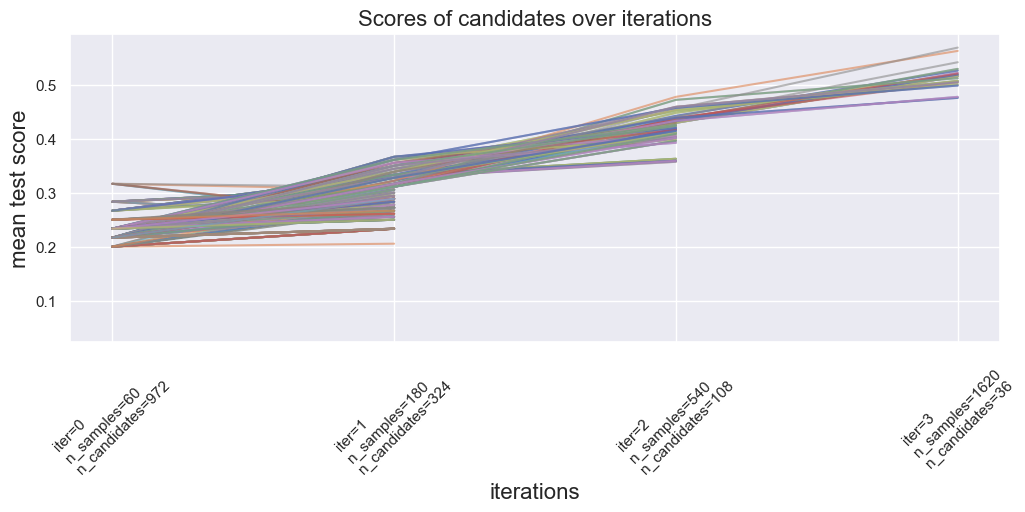

In [76]:
plot_search(clf)

#### 4.1.5. Training and testing the model

In [77]:
binning_kw_args = best_params['binning__kw_args']
classifier_params = {key.split('__')[1]: value for key, value in best_params.items() if 'classifier__' in key}

In [78]:
classifier_params

{'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 64,
 'hidden_layer_sizes': (100, 100, 100, 100),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.01,
 'max_iter': 1000,
 'random_state': 99,
 'solver': 'sgd'}

In [79]:
final_pipeline = Pipeline([
    ('binning', FunctionTransformer(func=into_bins_transform, kw_args=binning_kw_args)),
    ('classifier', MLPClassifier(**classifier_params))
])

In [80]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('binning',
                 FunctionTransformer(func=<function into_bins_transform at 0x000001D7FF29B040>,
                                     kw_args={'nb_bins': 40})),
                ('classifier',
                 MLPClassifier(alpha=0.001, batch_size=64,
                               hidden_layer_sizes=(100, 100, 100, 100),
                               learning_rate='adaptive',
                               learning_rate_init=0.01, max_iter=1000,
                               random_state=99, solver='sgd'))])

In [81]:
y_pred = final_pipeline.predict(X_test)

In [82]:
acc = accuracy_score(y_test, y_pred)
p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
print (f'f-macro average:{f.mean()}, accuracy_score = {acc}')

f-macro average:0.6281006823709677, accuracy_score = 0.63


In [83]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.61      0.63        62
           1       0.59      0.57      0.58        58
           2       0.60      0.59      0.59        56
           3       0.48      0.47      0.48        62
           4       0.53      0.44      0.48        63
           5       0.64      0.61      0.63        62
           6       0.74      0.82      0.78        56
           7       0.74      0.88      0.80        58
           8       0.61      0.60      0.60        62
           9       0.68      0.74      0.71        61

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.63       600
weighted avg       0.62      0.63      0.63       600



### 4.2. Input Type: Short-Time Fourier Transform (STFT)

#### 4.2.1. Visualization of an example

In [84]:
n_fft = int(0.04 * SAMPLING_RATE)
hop_length = int(0.02 * SAMPLING_RATE)

In [85]:
def plot_stft(x):
    STFT = librosa.stft(y=x, n_fft=n_fft, hop_length=hop_length)
    STFT_db = librosa.amplitude_to_db(np.abs(STFT), ref=np.max)
    
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(STFT_db, sr=SAMPLING_RATE, hop_length=hop_length, x_axis='s', y_axis='log')
    plt.xlabel("Time (s)")
    plt.ylabel("Hz")
    plt.colorbar()
    plt.title("STFT", fontsize= FONT_SIZE)

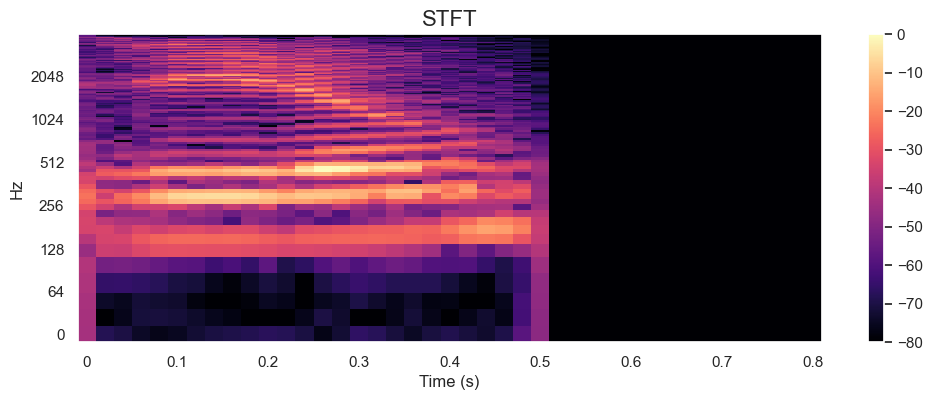

In [86]:
plot_stft(signal_t)

#### 4.2.2. STFT computation

In [87]:
X_stft = [librosa.stft(y=x, n_fft=n_fft, hop_length=hop_length) for x in X_norm]

In [88]:
X_stft = np.abs(X_stft)

In [89]:
np.array(X_stft).shape

(3000, 161, 41)

In [90]:
X_stft_1d = [x.flatten() for x in X_stft]

In [91]:
np.array(X_stft_1d).shape

(3000, 6601)

In [92]:
X = np.array(X_stft_1d)

#### 4.2.3. Split the data into training and testing sets

In [93]:
print(f"- X.shape = {X.shape} \t- y.shape = {y.shape}")

- X.shape = (3000, 6601) 	- y.shape = (3000,)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

In [95]:
print(f"""
- X_train.shape = {X_train.shape} \t- y_train.shape = {y_train.shape}
- X_test.shape \t= {X_test.shape} \t- y_test.shape \t= {y_test.shape}
""")


- X_train.shape = (2400, 6601) 	- y_train.shape = (2400,)
- X_test.shape 	= (600, 6601) 	- y_test.shape 	= (600,)



#### 4.2.4. Define pipeline

In [96]:
pipeline = Pipeline([
    ('binning', bin_stats_transformer),
    ('classifier', MLPClassifier())
])

#### 4.2.5. Hyperparameters tuning

In [97]:
# clf = GridSearchCV(**grid_search_params)

In [98]:
clf = HalvingGridSearchCV(resource='n_samples',
                          **grid_search_params
                         )

In [99]:
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

n_iterations: 4
n_required_iterations: 7
n_possible_iterations: 4
min_resources_: 60
max_resources_: 2400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 972
n_resources: 60
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
----------
iter: 1
n_candidates: 324
n_resources: 180
Fitting 3 folds for each of 324 candidates, totalling 972 fits
----------
iter: 2
n_candidates: 108
n_resources: 540
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 3
n_candidates: 36
n_resources: 1620
Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [100]:
elapsed_time_s = end_time - start_time
print(f"Hyperparameters Optimization took: {int(elapsed_time_s//60)} min {int(elapsed_time_s%60)} sec")

Hyperparameters Optimization took: 24 min 5 sec


In [101]:
best_params = clf.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'binning__kw_args': {'nb_bins': 20}, 'classifier__activation': 'tanh', 'classifier__alpha': 0.001, 'classifier__batch_size': 128, 'classifier__hidden_layer_sizes': (100, 100, 100, 100), 'classifier__learning_rate': 'adaptive', 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 1000, 'classifier__random_state': 99, 'classifier__solver': 'adam'}


In [102]:
y_pred = clf.predict(X_test)

In [103]:
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred)}")

Accuracy on Test Set: 0.9516666666666667


In [104]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94        62
           1       0.95      0.98      0.97        58
           2       0.96      0.93      0.95        56
           3       0.92      0.90      0.91        62
           4       1.00      0.95      0.98        63
           5       0.97      0.97      0.97        62
           6       0.91      0.95      0.93        56
           7       0.97      1.00      0.98        58
           8       0.98      0.94      0.96        62
           9       0.91      0.97      0.94        61

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



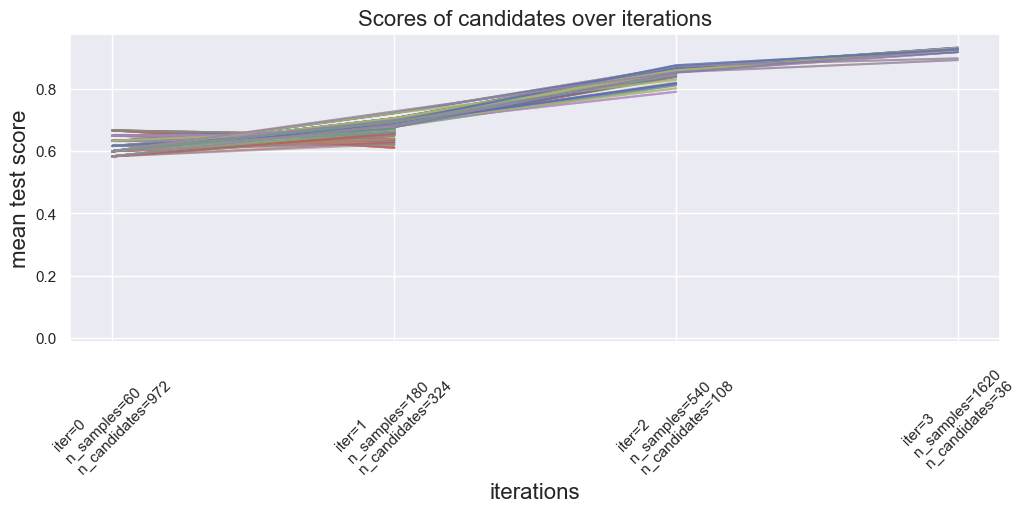

In [105]:
plot_search(clf)

#### 4.2.6. Training and testing the model

In [106]:
binning_kw_args = best_params['binning__kw_args']
classifier_params = {key.split('__')[1]: value for key, value in best_params.items() if 'classifier__' in key}

In [107]:
classifier_params

{'activation': 'tanh',
 'alpha': 0.001,
 'batch_size': 128,
 'hidden_layer_sizes': (100, 100, 100, 100),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_iter': 1000,
 'random_state': 99,
 'solver': 'adam'}

In [108]:
final_pipeline = Pipeline([
    ('binning', FunctionTransformer(func=into_bins_transform, kw_args=binning_kw_args)),
    ('classifier', MLPClassifier(**classifier_params))
])

In [109]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('binning',
                 FunctionTransformer(func=<function into_bins_transform at 0x000001D7FF29B040>,
                                     kw_args={'nb_bins': 20})),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=0.001, batch_size=128,
                               hidden_layer_sizes=(100, 100, 100, 100),
                               learning_rate='adaptive', max_iter=1000,
                               random_state=99))])

In [110]:
y_pred = final_pipeline.predict(X_test)

In [111]:
acc = accuracy_score(y_test, y_pred)
p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
print (f'f-macro average:{f.mean()}, accuracy_score = {acc}')

f-macro average:0.9516627499856083, accuracy_score = 0.9516666666666667


In [112]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94        62
           1       0.95      0.98      0.97        58
           2       0.96      0.93      0.95        56
           3       0.92      0.90      0.91        62
           4       1.00      0.95      0.98        63
           5       0.97      0.97      0.97        62
           6       0.91      0.95      0.93        56
           7       0.97      1.00      0.98        58
           8       0.98      0.94      0.96        62
           9       0.91      0.97      0.94        61

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



### 4.3. Input Type: Mel-frequency Cepstral Coefficients (MFCCs)

The following figure [1] presents a diagram summarizing the steps for calculating **Mel-Frequency Cepstral Coefficients (MFCC)** from an audio signal on the Mel scale.

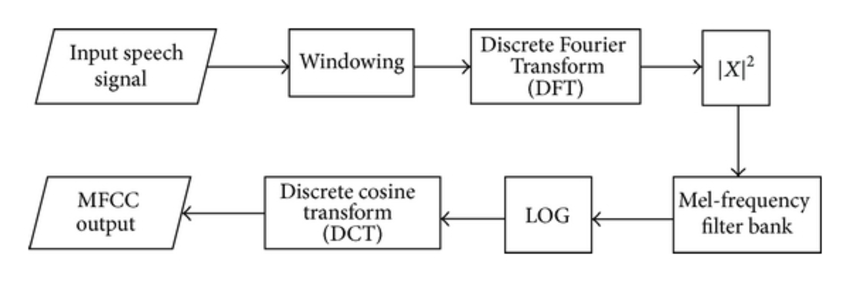

[1] Surendra Thakur, Emmanuel Adetiba, Oludayo O. Olugbara, Richard Millham, "Experimentation Using Short-Term Spectral Features for Secure Mobile Internet Voting Authentication", Mathematical Problems in Engineering, vol. 2015, Article ID 564904, 21 pages, 2015. https://doi.org/10.1155/2015/564904

#### 4.3.1. Visualization of an example

In [113]:
n_fft = int(0.04 * SAMPLING_RATE)
hop_length = int(0.02 * SAMPLING_RATE)
n_mfcc = 20

In [114]:
signal_t.shape

(6457,)

In [115]:
def plot_mfcc(x):
  MFCC = librosa.feature.mfcc(y=x, sr=SAMPLING_RATE, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)

  plt.figure(figsize=FIG_SIZE)
  librosa.display.specshow(MFCC, sr=SAMPLING_RATE, hop_length=hop_length, x_axis='s', y_axis='linear')
  plt.xlabel("Time (s)")
  plt.ylabel("Hz")
  plt.colorbar()
  plt.title("MFCC", fontsize= FONT_SIZE)

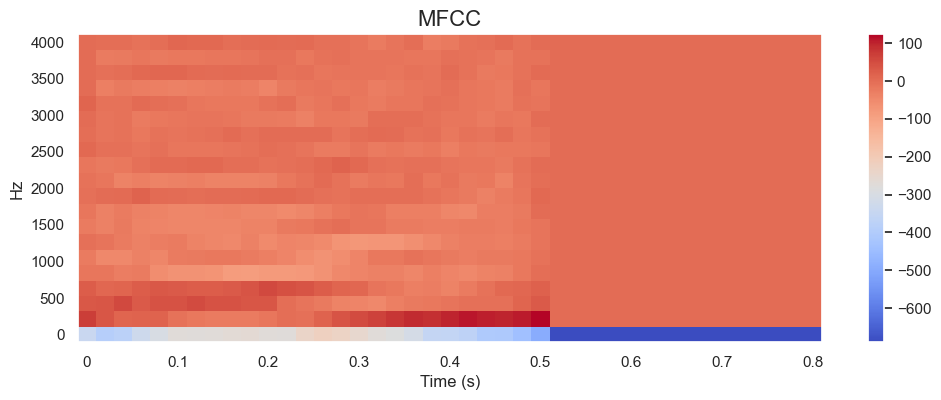

In [116]:
plot_mfcc(signal_t)

#### 4.3.2. MFCC computation

In [117]:
X_mfcc = [librosa.feature.mfcc(y=x, sr=SAMPLING_RATE, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc) for x in X_norm]

In [118]:
np.array(X_mfcc).shape

(3000, 20, 41)

In [119]:
X_mfcc_1d = [x.flatten() for x in X_mfcc]

In [120]:
np.array(X_mfcc_1d).shape

(3000, 820)

In [121]:
X = np.array(X_mfcc_1d)

#### 4.3.3. Split the data into training and testing sets

In [122]:
print(f"- X.shape = {X.shape} \t- y.shape = {y.shape}")

- X.shape = (3000, 820) 	- y.shape = (3000,)


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

In [124]:
print(f"""
- X_train.shape = {X_train.shape} \t- y_train.shape = {y_train.shape}
- X_test.shape \t= {X_test.shape} \t- y_test.shape \t= {y_test.shape}
""")


- X_train.shape = (2400, 820) 	- y_train.shape = (2400,)
- X_test.shape 	= (600, 820) 	- y_test.shape 	= (600,)



#### 4.3.4. Define pipeline

In [125]:
pipeline = Pipeline([
    ('binning', bin_stats_transformer),
    ('classifier', MLPClassifier())
])

#### 4.3.5. Hyperparameters tuning

In [126]:
# clf = GridSearchCV(**grid_search_params)

In [127]:
clf = HalvingGridSearchCV(resource='n_samples',
                          **grid_search_params
                         )

In [128]:
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

n_iterations: 4
n_required_iterations: 7
n_possible_iterations: 4
min_resources_: 60
max_resources_: 2400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 972
n_resources: 60
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
----------
iter: 1
n_candidates: 324
n_resources: 180
Fitting 3 folds for each of 324 candidates, totalling 972 fits
----------
iter: 2
n_candidates: 108
n_resources: 540
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 3
n_candidates: 36
n_resources: 1620
Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [129]:
elapsed_time_s = end_time - start_time
print(f"Hyperparameters Optimization took: {int(elapsed_time_s//60)} min {int(elapsed_time_s%60)} sec")

Hyperparameters Optimization took: 21 min 26 sec


In [130]:
best_params = clf.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'binning__kw_args': {'nb_bins': 60}, 'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__batch_size': 256, 'classifier__hidden_layer_sizes': (100, 100, 100, 100), 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 1000, 'classifier__random_state': 99, 'classifier__solver': 'adam'}


In [131]:
y_pred = clf.predict(X_test)

In [132]:
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred)}")

Accuracy on Test Set: 0.9783333333333334


In [133]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       0.98      1.00      0.99        58
           2       0.98      0.98      0.98        56
           3       0.98      0.97      0.98        62
           4       1.00      1.00      1.00        63
           5       1.00      0.98      0.99        62
           6       0.90      0.98      0.94        56
           7       0.98      0.97      0.97        58
           8       1.00      0.92      0.96        62
           9       0.95      0.98      0.97        61

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



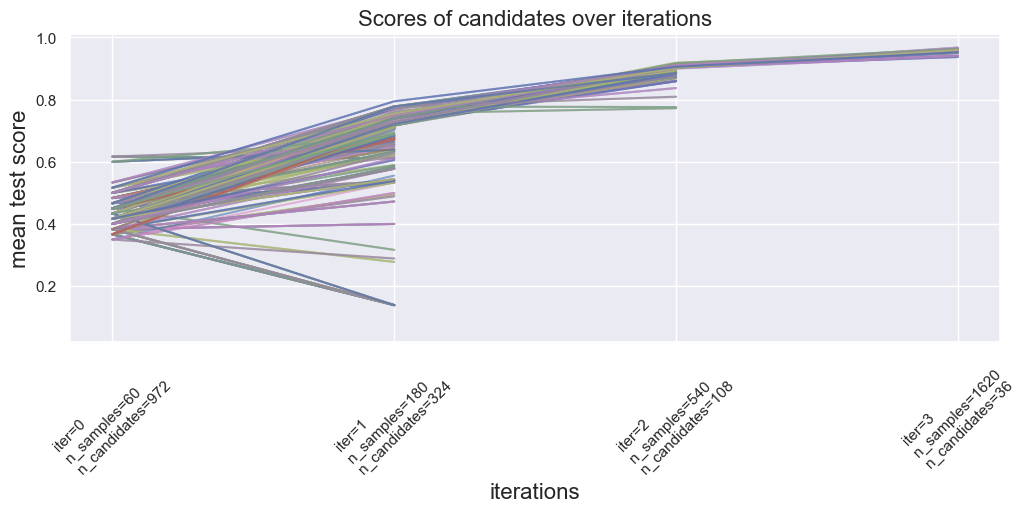

In [134]:
plot_search(clf)

#### 4.3.6. Training and testing the model

In [135]:
binning_kw_args = best_params['binning__kw_args']
classifier_params = {key.split('__')[1]: value for key, value in best_params.items() if 'classifier__' in key}

In [136]:
classifier_params

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 256,
 'hidden_layer_sizes': (100, 100, 100, 100),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 1000,
 'random_state': 99,
 'solver': 'adam'}

In [137]:
final_pipeline = Pipeline([
    ('binning', FunctionTransformer(func=into_bins_transform, kw_args=binning_kw_args)),
    ('classifier', MLPClassifier(**classifier_params))
])

In [138]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('binning',
                 FunctionTransformer(func=<function into_bins_transform at 0x000001D7FF29B040>,
                                     kw_args={'nb_bins': 60})),
                ('classifier',
                 MLPClassifier(batch_size=256,
                               hidden_layer_sizes=(100, 100, 100, 100),
                               max_iter=1000, random_state=99))])

In [139]:
y_pred = final_pipeline.predict(X_test)

In [140]:
acc = accuracy_score(y_test, y_pred)
p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
print (f'f-macro average:{f.mean()}, accuracy_score = {acc}')

f-macro average:0.9780884635802979, accuracy_score = 0.9783333333333334


In [141]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       0.98      1.00      0.99        58
           2       0.98      0.98      0.98        56
           3       0.98      0.97      0.98        62
           4       1.00      1.00      1.00        63
           5       1.00      0.98      0.99        62
           6       0.90      0.98      0.94        56
           7       0.98      0.97      0.97        58
           8       1.00      0.92      0.96        62
           9       0.95      0.98      0.97        61

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



## 5. Conclusion:

In this exploration of speech recognition using neural networks, the classification of English numbers within audio recordings was investigated through a Multilayer Perceptron (MLP) model. Three distinct speech signal representations: Time-domain Signal, Mel Frequency Cepstral Coefficients (MFCC), and Short-Time Fourier Transform (STFT) were emphasized.

The obtained results showcase the effectiveness of these representations in capturing and discerning essential features within the audio data. The F1 Score and Accuracy metrics provide valuable insights into the model's performance across different input types:

- **Time-domain Signal:**

    - F1 Score: 0.628
    - Accuracy: 0.63
      
> The raw time-domain signal's performance, while indicative of the model's ability to capture basic features, falls short in achieving high precision and recall. This suggests that the inherent complexities of speech patterns may not be adequately represented in the time-domain alone.

- **Short-Time Fourier Transform (STFT):**

    - F1 Score: 0.951
    - Accuracy: 0.951
      
> The STFT representation also demonstrated commendable performance, although slightly trailing behind MFCC. The ability of STFT to analyze variations in frequency over time proved valuable for the classification task, albeit with a marginal reduction in performance compared to MFCC.

- **Mel Frequency Cepstral Coefficients (MFCC):**

    - F1 Score: 0.978
    - Accuracy: 0.978
      
> The utilization of MFCC as a representation significantly improved the model's performance. The high F1 Score and Accuracy metrics indicate that the model successfully leveraged the frequency-domain features captured by MFCC, showcasing its robustness in handling speech signal classification tasks.

In conclusion, these findings underscore the importance of selecting an appropriate signal representation for speech recognition tasks. While time-domain signals provide a foundational understanding, the superior performance of the model when using MFCC highlights the significance of frequency-domain features in capturing intricate nuances within speech patterns. The STFT representation, while not surpassing MFCC, remains a viable option, showcasing its competence in similar applications.

This comparative analysis contributes valuable insights for future endeavors in speech signal processing, emphasizing the crucial role of feature representation in enhancing the performance of neural network models for speech recognition tasks.